# Marrying Grounding DINO with GLIGEN for Image Editing


[![Grounding DINO](https://badges.aleen42.com/src/github.svg)](https://github.com/IDEA-Research/GroundingDINO)
[![GLIGEN](https://badges.aleen42.com/src/github.svg)](https://github.com/gligen/GLIGEN)


[![arXiv](https://img.shields.io/badge/arXiv-2303.05499-b31b1b.svg)](https://arxiv.org/abs/2303.05499) 
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/wxWDt5UiwY8)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/cMa77r3YrDk)
[![HuggingFace space](https://img.shields.io/badge/🤗-HuggingFace%20Space-cyan.svg)](https://huggingface.co/spaces/ShilongLiu/Grounding_DINO_demo)

# Build environment

**GLIGEN uses a modified diffusers. We highly recommoned to use new conda virtural environment for the notebook!**

To do this, please run the following commands and rerun the notebook with the new environment:

```bash
conda create -n gligen_diffusers python=3.10
conda activate gligen_diffusers
```

In [1]:
! pip install diffusers transformers accelerate scipy safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:0000:0100:01


In [2]:
# install gligen_diffusers
! pwd
! git clone git@github.com:gligen/diffusers.git
! python -m pip install -e diffusers

/home/pcarragh/dev/webqa/segment/MultimodalEntitySubstitution/demo
Cloning into 'diffusers'...
The authenticity of host 'github.com (140.82.113.3)' can't be established.
ECDSA key fingerprint is SHA256:p2QAMXNIC1TJYWeIOttrVc98/R1BUFWu3/LiyKgUfQM.
Are you sure you want to continue connecting (yes/no/[fingerprint])? ^C
ERROR: diffusers is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [1]:
import os

# setup device. If you have a GPU, you can change this to "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import argparse
from functools import partial
import cv2
import requests

from io import BytesIO
from PIL import Image
import numpy as np
from pathlib import Path
import random


import warnings
warnings.filterwarnings("ignore")


import torch
from torchvision.ops import box_convert

from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from groundingdino.util.inference import annotate, load_image, predict
import groundingdino.datasets.transforms as T

from huggingface_hub import hf_hub_download


# Load grounding dino models

In [3]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model    

In [4]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swint_ogc.pth"
ckpt_config_filename = "GroundingDINO_SwinT_OGC.cfg.py"

In [5]:
model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

final text_encoder_type: bert-base-uncased


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Model loaded from /home/pcarragh/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


# Load GLIGEN inpainting models

In [6]:
from diffusers import StableDiffusionGLIGENPipeline


pipe = StableDiffusionGLIGENPipeline.from_pretrained("gligen/diffusers-inpainting-text-box", revision="fp16", torch_dtype=torch.float16)
pipe.to("cuda")

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.4.0+cu121)
    Python  3.8.16 (you have 3.8.19)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


unet/diffusion_pytorch_model.safetensors not found


StableDiffusionGLIGENPipeline {
  "_class_name": "StableDiffusionGLIGENPipeline",
  "_diffusers_version": "0.15.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Load demo image

In [7]:
image_url = 'https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/art_dog_birthdaycake.png'
local_image_path = 'art_dog_birthdaycake.png'

In [8]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

download_image(image_url, local_image_path)

Image downloaded from url: https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/art_dog_birthdaycake.png and saved to: art_dog_birthdaycake.png.


# Run Grounding DINO

In [40]:
import os
import supervision as sv


TEXT_PROMPT = "dog. cake."
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(local_image_path)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

# image_source: np.ndarray
# annotated_frame: np.ndarray

In [10]:
def generate_masks_with_grounding(image_source, boxes):
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0, x1, y1 = box
        mask[int(y0):int(y1), int(x0):int(x1), :] = 255
    return mask

In [11]:
image_mask = generate_masks_with_grounding(image_source, boxes)

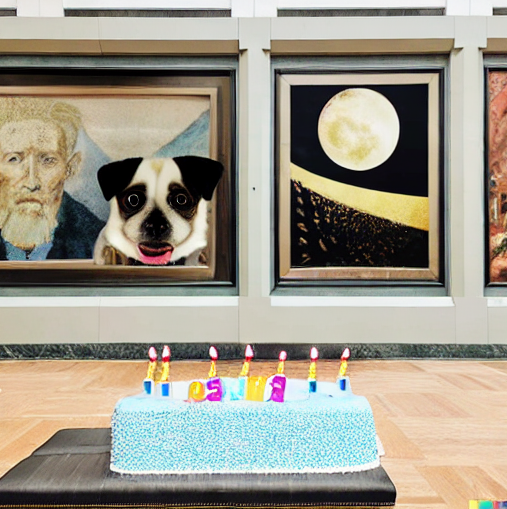

In [12]:
Image.fromarray(image_source)

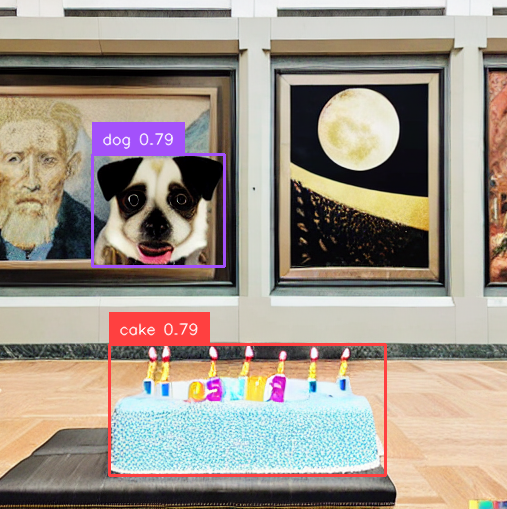

In [13]:
Image.fromarray(annotated_frame)

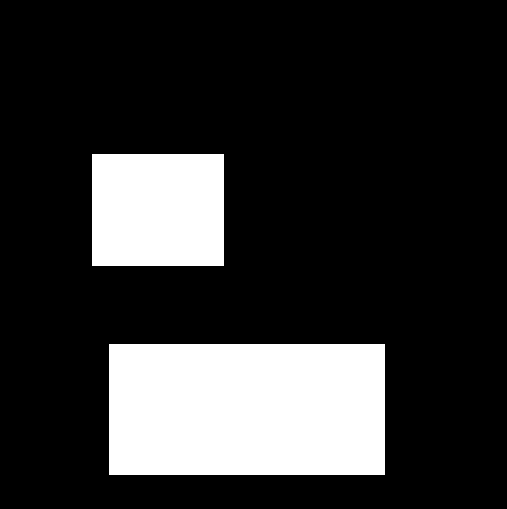

In [14]:
Image.fromarray(image_mask)

# Image Inpainting

In [15]:
image_source = Image.fromarray(image_source)
annotated_frame = Image.fromarray(annotated_frame)
image_mask = Image.fromarray(image_mask)

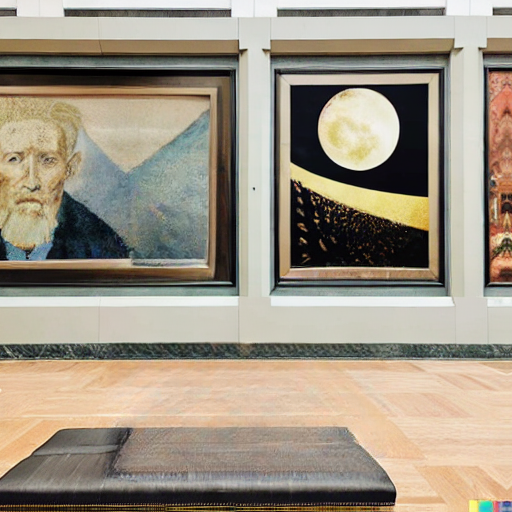

In [47]:
from simple_lama_inpainting import SimpleLama
from PIL import Image

simple_lama = SimpleLama()

# image = Image.fromarray(image_source)
# mask = Image.fromarray(image_mask).convert('L')
# mask = Image.open(mask_path).convert('L')

simple_lama(image_source, image_mask.convert("L"))
# result.save("inpainted.png")

In [16]:
image_source_for_inpaint = image_source.resize((512, 512))
image_mask_for_inpaint = image_mask.resize((512, 512))

In [17]:
num_box = len(boxes)
num_box

2

In [18]:
xyxy_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").tolist()
xyxy_boxes[:2]

[[0.1819545030593872,
  0.30422443151474,
  0.4422849416732788,
  0.5236873030662537],
 [0.2155449390411377,
  0.6760771870613098,
  0.7596598267555237,
  0.9342504143714905]]

  0%|          | 0/50 [00:00<?, ?it/s]

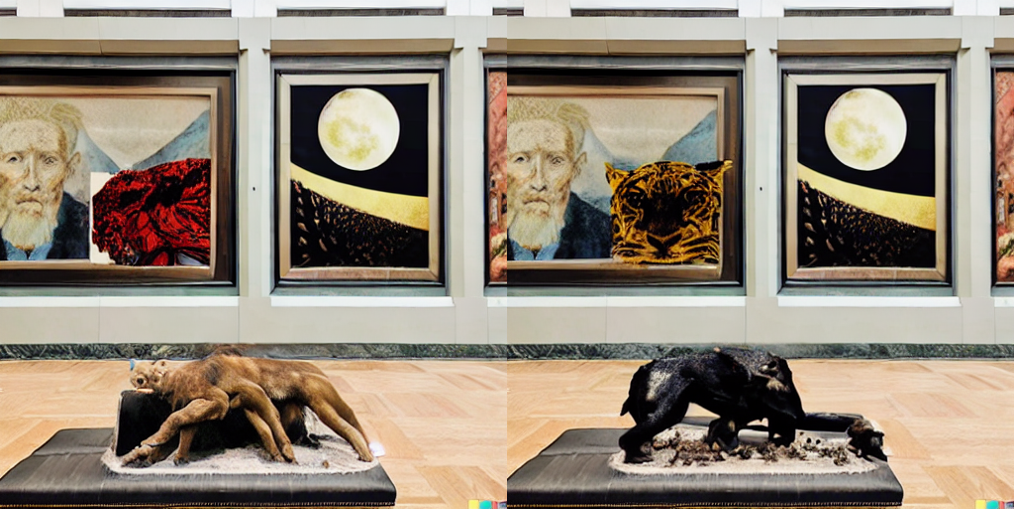

In [37]:
word = 'savage'

prompt = f"'{word}', '{word}'"
gligen_phrases = [word, word]
num_box = len(boxes)

image_inpainting = pipe(
    prompt,
    num_images_per_prompt = 2,
    gligen_phrases = gligen_phrases,
    gligen_inpaint_image = image_source_for_inpaint,
    gligen_boxes = xyxy_boxes,
    gligen_scheduled_sampling_beta=1,
    output_type="numpy",
    num_inference_steps=50
).images

# 0..1 to 0..255, and convert to uint8
image_inpainting = (image_inpainting * 255).astype(np.uint8)
image_inpainting = np.concatenate(image_inpainting, axis=1)
Image.fromarray(image_inpainting).resize((image_source.size[0]*2, image_source.size[1]))

In [38]:
import torch
import torch.version
torch.version.__version__

'2.4.0+cu121'